In [2]:
!pip install -U portalocker>=2.0.0 optuna-integration

## Task - 1

### PyTorch FC ANN MNIST Implementation.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import optuna
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
from optuna.integration import PyTorchLightningPruningCallback

In [4]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64
train_val_split = 0.8

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate sizes
train_size = int(train_val_split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [5]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [6]:
# Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): # MLP stands for "Multi-Layer Perceptron"
    def __init__(self, layer_sizes, activation_functions): # this initializes the structure of the network
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = 28 * 28 ## 28*28 input features and 32 outputs
        for size in layer_sizes:
            self.layers.append(nn.Linear(input_size, size))
            input_size = size
        
        self.activation_functions = activation_functions
        self.output_layer = nn.Linear(input_size, 10) ## 10 output features because MNIST has 10 target classes

    def forward(self, x): # this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28)  # Flatten the input
        for layer, activation in zip(self.layers, self.activation_functions):
            x = activation(layer(x))
        x = self.output_layer(x)
        return x

In [7]:
def objective(trial):
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 2, 4)
    layer_sizes = []
    activation_functions = []
    activations = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        # Add more if needed
    }

    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'RMSprop': optim.RMSprop,
        # Add more optimizers if desired
    }

    for i in range(num_layers):
        layer_size = trial.suggest_categorical(f'layer_size_{i}', [32, 64, 128, 256])
        activation_name = trial.suggest_categorical(f'activation_{i}', ['relu', 'sigmoid', 'tanh'])
        layer_sizes.append(layer_size)
        activation_functions.append(activations[activation_name])

    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])

    # Suggest learning rate
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    # Suggest weight decay (L2 regularization)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)

    # Suggest batch size
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Initialize the model
    model = MLP(layer_sizes, activation_functions)
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    optimizer_class = optimizers[optimizer_name]
    if optimizer_name == 'SGD':
        # Suggest momentum for SGD
        momentum = trial.suggest_uniform('momentum', 0.0, 0.9)
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Data loaders with suggested batch size
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Training loop
    num_epochs = 5  # Adjust as needed
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)

[I 2024-10-17 09:19:17,813] A new study created in memory with name: no-name-7a51d881-bb0d-4b97-8581-83e3fb79fc14
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_4412\2204145081.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_4412\2204145081.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_4412\2204145081.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.

Best hyperparameters: {'num_layers': 4, 'layer_size_0': 128, 'activation_0': 'relu', 'layer_size_1': 256, 'activation_1': 'tanh', 'layer_size_2': 32, 'activation_2': 'relu', 'layer_size_3': 128, 'activation_3': 'relu', 'optimizer': 'SGD', 'lr': 0.006808817137082687, 'weight_decay': 1.4154590111434038e-05, 'batch_size': 32, 'momentum': 0.8827750523526923}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [39]:
model = MLP([256, 256], [nn.ReLU(), nn.Tanh()]) # from best params above
# 0.002, 0.001
learning_rate = 0.017687904254669623
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001304789704792876, momentum=0.1894720749043393)

# Data loaders with suggested batch size
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Training the neural network
# 3, 10, 20
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

    running_loss = 0.0  # Reset running loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'Validation Loss: {running_loss / len(val_loader)}')
    model.train()  # Set model back to training mode

print('Finished Training')

Epoch 1, Batch 100, Loss: 2.1516267788410186
Epoch 1, Batch 200, Loss: 1.6584284210205078
Epoch 1, Batch 300, Loss: 1.145043471455574
Epoch 1, Batch 400, Loss: 0.9123734623193741
Epoch 1, Batch 500, Loss: 0.7727144131064415
Epoch 1, Batch 600, Loss: 0.6891837051510811
Epoch 1, Batch 700, Loss: 0.5949320143461228
Epoch 1, Batch 800, Loss: 0.5923074644804001
Epoch 1, Batch 900, Loss: 0.55057936668396
Epoch 1, Batch 1000, Loss: 0.5502334982156754
Epoch 1, Batch 1100, Loss: 0.5631349927186966
Epoch 1, Batch 1200, Loss: 0.5101337702572346
Epoch 1, Batch 1300, Loss: 0.5203005151450634
Epoch 1, Batch 1400, Loss: 0.4783757564425468
Epoch 1, Batch 1500, Loss: 0.4745977507531643
Validation Loss: 0.4789267548720042
Epoch 2, Batch 100, Loss: 0.4644384044408798
Epoch 2, Batch 200, Loss: 0.4625648429989815
Epoch 2, Batch 300, Loss: 0.45634143337607386
Epoch 2, Batch 400, Loss: 0.406360377073288
Epoch 2, Batch 500, Loss: 0.4395082722604275
Epoch 2, Batch 600, Loss: 0.43375724986195563
Epoch 2, Batch 

In [41]:
# Evaluating the model
model.eval()
correct = 0
total = 0
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.9581%


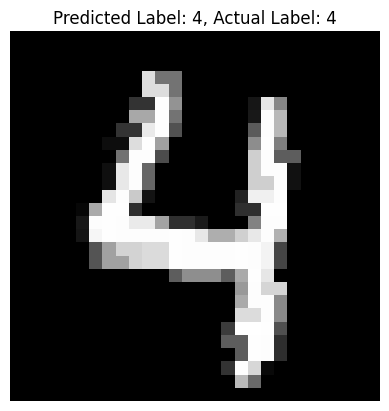

In [42]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation function:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## Task - 2

### PyTorch FC ANN FMNIST Implementation


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [44]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.Normalize((0.5,), (0.5,))])

train_val_split = 0.8

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Calculate sizes
train_size = int(train_val_split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [45]:
# Mapping the labels for the FashionMNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

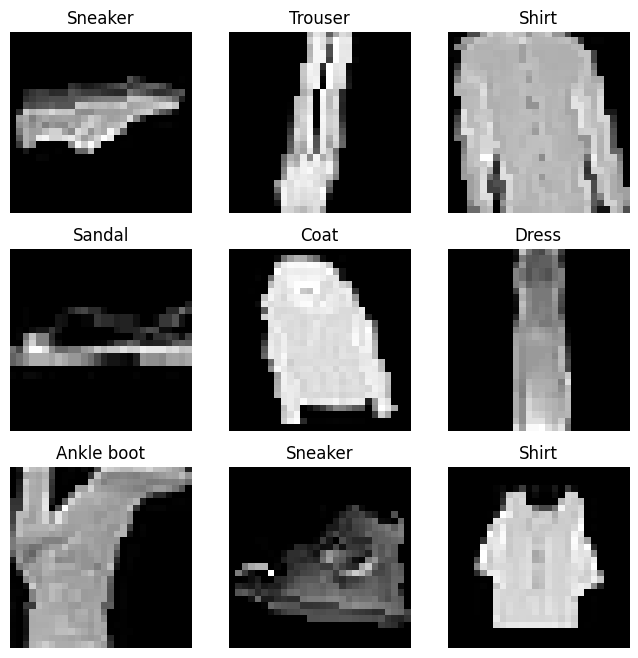

In [46]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [47]:
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)

[I 2024-10-16 15:20:41,046] A new study created in memory with name: no-name-60f62d75-dfae-46a3-b68a-4b177184032e
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_9416\3238854038.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_9416\3238854038.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
[I 2024-10-16 15:23:46,202] Trial 0 finished with value: 0.09916666666666667 and parameters: {'num_layers': 4, 'layer_size_0': 128, 'activation_0': 'relu', 'layer_size_1': 256, 'activation_1': 'sigmoid', 'layer_size_2': 12

Best hyperparameters: {'num_layers': 2, 'layer_size_0': 128, 'activation_0': 'relu', 'layer_size_1': 128, 'activation_1': 'sigmoid', 'optimizer': 'RMSprop', 'lr': 0.001056853608332082, 'weight_decay': 5.301484414947403e-06, 'batch_size': 32}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [49]:
model = MLP([128, 128], [nn.ReLU(), nn.Sigmoid()]) # from best params above
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001056853608332082, weight_decay=5.301484414947403e-06)

# Data loaders with suggested batch size
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Training the neural network
# 3, 10, 20
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

    running_loss = 0.0  # Reset running loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'Validation Loss: {running_loss / len(val_loader)}')
    model.train()  # Set model back to training mode

print('Finished Training')

Epoch 1, Batch 100, Loss: 1.3447680562734603
Epoch 1, Batch 200, Loss: 0.9830856829881668
Epoch 1, Batch 300, Loss: 0.8845025140047074
Epoch 1, Batch 400, Loss: 0.8360383078455925
Epoch 1, Batch 500, Loss: 0.7992652341723442
Epoch 1, Batch 600, Loss: 0.7849914020299912
Epoch 1, Batch 700, Loss: 0.782193575501442
Epoch 1, Batch 800, Loss: 0.7744410452246666
Epoch 1, Batch 900, Loss: 0.7453978726267815
Epoch 1, Batch 1000, Loss: 0.7717109832167626
Epoch 1, Batch 1100, Loss: 0.7216164082288742
Epoch 1, Batch 1200, Loss: 0.7698494336009025
Epoch 1, Batch 1300, Loss: 0.7284211531281471
Epoch 1, Batch 1400, Loss: 0.7392239198088646
Epoch 1, Batch 1500, Loss: 0.7381336161494255
Validation Loss: 0.7300344111919403
Epoch 2, Batch 100, Loss: 0.7179026398062706
Epoch 2, Batch 200, Loss: 0.6826613938808441
Epoch 2, Batch 300, Loss: 0.7065676474571227
Epoch 2, Batch 400, Loss: 0.6843813115358353
Epoch 2, Batch 500, Loss: 0.6885463917255401
Epoch 2, Batch 600, Loss: 0.6924367928504944
Epoch 2, Batch

In [52]:
# Evaluating the model
model.eval()
correct = 0
total = 0
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}')

Accuracy on test set: 0.8062


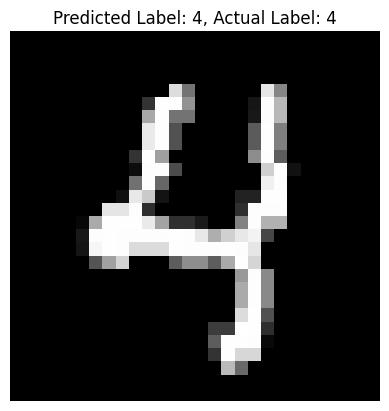

In [26]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

## PART - 3

### FMNIST CNN Implimentation with Keras

In [6]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np

In [2]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [3]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [19]:
model = Sequential([
    Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)),  # 16 filters (reduced), 3x3 kernel
    MaxPooling2D(pool_size=(5, 5)),  # Max pooling with 2x2 pool size
    # Flatten the output before passing to Dense layers
    Flatten(),
    Dense(64, activation='softmax'),  # Reduced from 128 to 64 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

## change the architecture with CONV2D, Pooling, and Dense.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
learning_rate = 0.01
epochs = 5
batch_size = 48

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0981 - loss: 2.3028
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0969 - loss: 2.3024
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0964 - loss: 2.3020
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1077 - loss: 2.3015
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0918 - loss: 2.3002
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0962 - loss: 2.2981
Test accuracy: 0.10000000149011612


In [13]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0951 - loss: 2.2976 - val_accuracy: 0.0782 - val_loss: 2.2944
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1121 - loss: 2.2928 - val_accuracy: 0.1810 - val_loss: 2.2860
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1941 - loss: 2.2815 - val_accuracy: 0.1964 - val_loss: 2.2593
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2090 - loss: 2.2439 - val_accuracy: 0.2071 - val_loss: 2.1862
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2047 - loss: 2.1652 - val_accuracy: 0.2084 - val_loss: 2.1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2142 - loss: 2.0979
Test accuracy: 0.2093999981880188


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


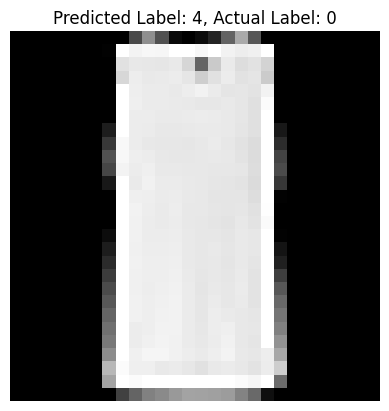

In [18]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

### Just to explore TensorFlow Implemenation of CNN.

Not Required For Submission.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='tanh'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1010 - loss: 2.3026
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0984 - loss: 2.3026
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1009 - loss: 2.3026
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1026 - loss: 2.3025
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1026 - loss: 2.3024
313/313 - 2s - 7ms/step - accuracy: 0.1000 - loss: 2.3023

Test accuracy: 0.10000000149011612


## AUTOMATED TUNING (EXETENDED)

In [ ]:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams